
$ \newcommand{\Bra}[1]{\left\langle #1 \right|} $
$ \newcommand{\Ket}[1]{\left| #1 \right\rangle} $

# Nuclear Spin Hamiltonian: Zeeman Basis V2 (inverted alpha)

In [2]:
# Load "autoreload" extension so that code can change; set it so modules are reloaded before execution
%load_ext autoreload
%autoreload 2

In [4]:
import os.path as op

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import e as e_charge
from scipy.constants import h, hbar, mega
from scipy.optimize import fsolve
import sympy as sp
from sympy.physics.matrices import msigma
from sympy.solvers.solveset import nonlinsolve

import nmrlib.core as nmr
import nmrlib.quantum as quant
from src import ROOT
from src.utils import find_max_min

FIGSIZE = mpl.rcParams["figure.figsize"]

class Bunch(object):
    def __init__(self, adict):
        self.__dict__.update(adict)
        
def eig_sort(E, V):
    idx = E.argsort()[::-1]   
    return E[idx], V[:,idx]

def angmom_ops(spin=sp.Rational(3, 2)):
    N = int(2*spin + 1)
    Ipm = {1: sp.zeros(N), -1: sp.zeros(N)}
    Iz = sp.zeros(N)
    for i in range(N):
        for j in range(N):
            m = spin - j
            for op in [1, -1]:
                const = sp.sqrt(spin*(spin + 1) - m*(m + op))
                if const == 0:
                    Ipm[op][i, j] = 0
                else:
                    Ipm[op][i, j] = sp.eye(N)[:, i].dot(const*sp.eye(N)[:, j - op])
            Iz[i, j] = sp.eye(N)[:, i].dot(m*sp.eye(N)[:, j])
            
    return Ipm[1], Ipm[-1], Iz

## Eigenstates and eigenenergies

The first step is to find the states and energies. We first define the spin operators.

In [5]:
sym = Bunch({})
sym.I = {}
Ip, Im, Iz = angmom_ops()
sym.I['x'] = (Ip + Im)/2
sym.I['y'] = (Ip - Im)/(2*sp.I)
sym.I['z'] = Iz

for i in ['x', 'y', 'z']:
    display(sym.I[i])

Matrix([
[        0, sqrt(3)/2,         0,         0],
[sqrt(3)/2,         0,         1,         0],
[        0,         1,         0, sqrt(3)/2],
[        0,         0, sqrt(3)/2,         0]])

Matrix([
[          0, -sqrt(3)*I/2,           0,            0],
[sqrt(3)*I/2,            0,          -I,            0],
[          0,            I,           0, -sqrt(3)*I/2],
[          0,            0, sqrt(3)*I/2,            0]])

Matrix([
[3/2,   0,    0,    0],
[  0, 1/2,    0,    0],
[  0,   0, -1/2,    0],
[  0,   0,    0, -3/2]])

It is easier to generate the Hamiltonian in the quadrupolar basis first.

In [6]:
sym.alpha, sym.delta = sp.symbols('alpha delta', real=True)#, positive=True)
sym.X = [None]*4
sym.Xp = [None]*4
for i in range(4):
    sym.X[i] = sp.eye(4)[:, i]
sym.Xp[0] = sp.cos(sym.delta)*sym.X[0] + sp.sin(sym.delta)*sym.X[2]
sym.Xp[3] = sp.cos(sym.delta)*sym.X[3] + sp.sin(sym.delta)*sym.X[1]
sym.Xp[1] = sp.cos(sym.delta)*sym.X[1] - sp.sin(sym.delta)*sym.X[3]
sym.Xp[2] = sp.cos(sym.delta)*sym.X[2] - sp.sin(sym.delta)*sym.X[0]
for xp in sym.Xp:
    display(xp)
Hq = np.diag([1, -1, -1, 1]) # Quadrupolar Hamiltonian
Iz_q = sp.zeros(4) # Iz
for i in range(4):
    for j in range(4):
        Iz_q[i, j] = sym.Xp[i].dot(sym.I['z']*sym.Xp[j])
TRIGSUBS = {sp.sin(sym.delta)**2: (1 - sp.cos(2*sym.delta))/2, sp.cos(sym.delta)**2: (sp.cos(2*sym.delta) + 1)/2}
Iz_q = sp.simplify(Iz_q).subs(TRIGSUBS)
display(Iz_q)
sym.H_qbasis = sp.simplify(sp.Matrix(Hq - sym.alpha*Iz_q))
sym.H_qbasis

Matrix([
[cos(delta)],
[         0],
[sin(delta)],
[         0]])

Matrix([
[          0],
[ cos(delta)],
[          0],
[-sin(delta)]])

Matrix([
[-sin(delta)],
[          0],
[ cos(delta)],
[          0]])

Matrix([
[         0],
[sin(delta)],
[         0],
[cos(delta)]])

Matrix([
[cos(2*delta) + 1/2,                  0,      -sin(2*delta),                   0],
[                 0, cos(2*delta) - 1/2,                  0,        sin(2*delta)],
[     -sin(2*delta),                  0, 1/2 - cos(2*delta),                   0],
[                 0,       sin(2*delta),                  0, -cos(2*delta) - 1/2]])

Matrix([
[-alpha*cos(2*delta) - alpha/2 + 1,                                 0,               alpha*sin(2*delta),                                0],
[                                0, -alpha*cos(2*delta) + alpha/2 - 1,                                0,              -alpha*sin(2*delta)],
[               alpha*sin(2*delta),                                 0, alpha*cos(2*delta) - alpha/2 - 1,                                0],
[                                0,               -alpha*sin(2*delta),                                0, alpha*cos(2*delta) + alpha/2 + 1]])

Now change to $ m $-basis by a unitary operator $ U = \sum_k \Ket{b^{(k)}} \Bra{a^{(k)}} $ (assuming going from $ A $ basis to $ B $ basis).

In [7]:
sym.U = sp.zeros(4, 4)
for k in range(4):
    bk = sym.X[k]
    ak = sym.Xp[k]
    sym.U += bk*ak.T
sym.U

Matrix([
[ cos(delta),          0, sin(delta),           0],
[          0, cos(delta),          0, -sin(delta)],
[-sin(delta),          0, cos(delta),           0],
[          0, sin(delta),          0,  cos(delta)]])

The Hamiltonian in the $ m $-basis is then $ U^\dagger H U $, with the following eigenenergies.

In [8]:
sym.H_mbasis = sp.simplify((sym.U.T*sym.H_qbasis*sym.U))
display(sym.H_mbasis)

a, b, c = sp.symbols('a b c')
H_temp = sp.Matrix([[-3*a + b, 0, c, 0], [0, -a - b, 0, c], [c, 0, a - b, 0], [0, c, 0, 3*a + b]])
eigvals_temp = list(H_temp.eigenvals())
eigvecs_temp = list(H_temp.eigenvects())
display(H_temp)

subs = {a: sym.alpha/2, b: sp.cos(2*sym.delta), c: sp.sin(2*sym.delta)}
for i in range(4):
    E = sp.simplify(sp.simplify(eigvals_temp[i].subs(subs)).subs(TRIGSUBS))
    V = sp.simplify(sp.simplify(eigvecs_temp[i][2][0].subs(subs)).subs(TRIGSUBS))
    display(E)
#    display(V)
    print('-'*80)

Matrix([
[-3*alpha/2 + cos(2*delta),                       0,           sin(2*delta),                        0],
[                        0, -alpha/2 - cos(2*delta),                      0,             sin(2*delta)],
[             sin(2*delta),                       0, alpha/2 - cos(2*delta),                        0],
[                        0,            sin(2*delta),                      0, 3*alpha/2 + cos(2*delta)]])

Matrix([
[-3*a + b,      0,     c,       0],
[       0, -a - b,     0,       c],
[       c,      0, a - b,       0],
[       0,      c,     0, 3*a + b]])

-alpha/2 - sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1)

--------------------------------------------------------------------------------


-alpha/2 + sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1)

--------------------------------------------------------------------------------


alpha/2 - sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1)

--------------------------------------------------------------------------------


alpha/2 + sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1)

--------------------------------------------------------------------------------


The eigenvectors are found manually (see paper I wrote for PHYS 784). In summary, using $ x_i $ to denote the components of the eigenstates, the Schrödinger Equation gives the following. The eigenstates are written below in the $ m $-basis along with the associated eigenenergies.

In [9]:
x1, x2, x3, x4 = sp.symbols('x_1 x_2 x_3 x_4')
X = sp.Matrix([x1, x2, x3, x4])
for i in range(4):
    E = sp.simplify(sp.simplify(eigvals_temp[i].subs(subs)).subs(TRIGSUBS))
    display(sp.simplify(sym.H_mbasis*X - E*X))
    display(E)
    print('-'*80)

Matrix([
[ -alpha*x_1 + x_1*sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) + x_1*cos(2*delta) + x_3*sin(2*delta)],
[              x_2*sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - x_2*cos(2*delta) + x_4*sin(2*delta)],
[  alpha*x_3 + x_1*sin(2*delta) + x_3*sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - x_3*cos(2*delta)],
[2*alpha*x_4 + x_2*sin(2*delta) + x_4*sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) + x_4*cos(2*delta)]])

-alpha/2 - sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1)

--------------------------------------------------------------------------------


Matrix([
[ -alpha*x_1 - x_1*sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) + x_1*cos(2*delta) + x_3*sin(2*delta)],
[             -x_2*sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - x_2*cos(2*delta) + x_4*sin(2*delta)],
[  alpha*x_3 + x_1*sin(2*delta) - x_3*sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) - x_3*cos(2*delta)],
[2*alpha*x_4 + x_2*sin(2*delta) - x_4*sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1) + x_4*cos(2*delta)]])

-alpha/2 + sqrt(alpha**2 - 2*alpha*cos(2*delta) + 1)

--------------------------------------------------------------------------------


Matrix([
[-2*alpha*x_1 + x_1*sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + x_1*cos(2*delta) + x_3*sin(2*delta)],
[  -alpha*x_2 + x_2*sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) - x_2*cos(2*delta) + x_4*sin(2*delta)],
[               x_1*sin(2*delta) + x_3*sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) - x_3*cos(2*delta)],
[   alpha*x_4 + x_2*sin(2*delta) + x_4*sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + x_4*cos(2*delta)]])

alpha/2 - sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1)

--------------------------------------------------------------------------------


Matrix([
[-2*alpha*x_1 - x_1*sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + x_1*cos(2*delta) + x_3*sin(2*delta)],
[  -alpha*x_2 - x_2*sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) - x_2*cos(2*delta) + x_4*sin(2*delta)],
[               x_1*sin(2*delta) - x_3*sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) - x_3*cos(2*delta)],
[   alpha*x_4 + x_2*sin(2*delta) - x_4*sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1) + x_4*cos(2*delta)]])

alpha/2 + sqrt(alpha**2 + 2*alpha*cos(2*delta) + 1)

--------------------------------------------------------------------------------


In [10]:
sym.beta, sym.eta = sp.symbols('beta eta', real=True, positive=True)

sym.E = {}
sym.V = {}
sym.E[0] = -sym.beta/2 + sp.sqrt((sym.beta - 1)**2 + sym.eta**2/3)
sym.V[0] = (sym.beta - 1 - sp.sqrt((sym.beta - 1)**2 + sym.eta**2/3))*sym.X[0] - (sym.eta/sp.sqrt(3))*sym.X[2]
sym.E[1] = sym.beta/2 - sp.sqrt((sym.beta + 1)**2 + sym.eta**2/3)
sym.V[1] = (sym.beta + 1 + sp.sqrt((sym.beta + 1)**2 + sym.eta**2/3))*sym.X[1] - (sym.eta/sp.sqrt(3))*sym.X[3]
sym.E[2] = -sym.beta/2 - sp.sqrt((sym.beta - 1)**2 + sym.eta**2/3)
sym.V[2] = (sym.beta - 1 - sp.sqrt((sym.beta - 1)**2 + sym.eta**2/3))*sym.X[2] + (sym.eta/sp.sqrt(3))*sym.X[0]
sym.E[3] = sym.beta/2 + sp.sqrt((sym.beta + 1)**2 + sym.eta**2/3)
sym.V[3] = (sym.beta + 1 + sp.sqrt((sym.beta + 1)**2 + sym.eta**2/3))*sym.X[3] + (sym.eta/sp.sqrt(3))*sym.X[1]
for i in range(4):
    display(sym.E[i], sym.V[i])

-beta/2 + sqrt(eta**2/3 + (beta - 1)**2)

Matrix([
[beta - sqrt(eta**2/3 + (beta - 1)**2) - 1],
[                                        0],
[                           -sqrt(3)*eta/3],
[                                        0]])

beta/2 - sqrt(eta**2/3 + (beta + 1)**2)

Matrix([
[                                        0],
[beta + sqrt(eta**2/3 + (beta + 1)**2) + 1],
[                                        0],
[                           -sqrt(3)*eta/3]])

-beta/2 - sqrt(eta**2/3 + (beta - 1)**2)

Matrix([
[                            sqrt(3)*eta/3],
[                                        0],
[beta - sqrt(eta**2/3 + (beta - 1)**2) - 1],
[                                        0]])

beta/2 + sqrt(eta**2/3 + (beta + 1)**2)

Matrix([
[                                        0],
[                            sqrt(3)*eta/3],
[                                        0],
[beta + sqrt(eta**2/3 + (beta + 1)**2) + 1]])

Now, we compare the analytical expressions to numerical evaluation.

In [11]:
rho = sp.sqrt(1 + sym.eta**2/3)
sind = sp.sqrt((rho - 1)/(2*rho))
cosd = sp.sqrt((rho + 1)/(2*rho))
subs = {sym.alpha: sym.beta/rho,
        sp.sin(2*sym.delta): 2*sind*cosd,
        sp.cos(2*sym.delta): 1 - 2*sind**2}
_H = -sym.beta*sym.I['z'] + sp.Rational(1, 3)*(3*sym.I['z']**2 - (sym.I['x']**2 + sym.I['y']**2 + sym.I['z']**2)
                                             + sym.eta*(sym.I['x']**2 - sym.I['y']**2))
H_num = sp.simplify(_H)
display(H_num)
H_num_func = sp.lambdify([sym.beta, sym.eta], H_num)
H = sp.simplify((rho*sym.H_mbasis).subs(subs))
H_func = sp.lambdify([sym.beta, sym.eta], H)
display(H)

e = {}
v = {}
for i in range(4):
    e[i] = sp.lambdify([sym.beta, sym.eta], sym.E[i])
    v[i] = sp.lambdify([sym.beta, sym.eta], sym.V[i]/sp.sqrt(sym.V[i].dot(sym.V[i])))

beta = np.linspace(0, 2)
eta = 0.6
for b in beta:
    _E_num, _V_num = np.linalg.eigh(H_num_func(b, eta))
    E_num, V_num = eig_sort(_E_num, _V_num)
#     print(H_num_func(b, eta))
#     print(_V_num)
    
    
    _E = np.array([e[i](b, eta) for i in range(4)])
    _V = np.array([v[i](b, eta).T for i in range(4)]).squeeze().T
    E, V = eig_sort(_E, _V)
    for i in range(4):
        check = np.matmul(H_func(b, eta), v[i](b, eta).squeeze()) - e[i](b, eta)*v[i](b, eta).squeeze()
        if np.all(np.isclose(check, np.zeros(4))):
            pass
        else:
            print('HV = EV not satisfied', check)

        if np.all(np.isclose(V[:, i], V_num[:, i])) or np.all(np.isclose(-V[:, i], V_num[:, i])):
            pass
        else:
            print('numerical and analytical solutions not matching up')
            print('beta = ', b, i)
            print(E[i])
            print(E_num[i])
            print(V[:, i])
            print(V_num[:, i])
        
    print('='*80)

Matrix([
[ 1 - 3*beta/2,             0, sqrt(3)*eta/3,             0],
[            0,   -beta/2 - 1,             0, sqrt(3)*eta/3],
[sqrt(3)*eta/3,             0,    beta/2 - 1,             0],
[            0, sqrt(3)*eta/3,             0,  3*beta/2 + 1]])

Matrix([
[ 1 - 3*beta/2,             0, sqrt(3)*eta/3,             0],
[            0,   -beta/2 - 1,             0, sqrt(3)*eta/3],
[sqrt(3)*eta/3,             0,    beta/2 - 1,             0],
[            0, sqrt(3)*eta/3,             0,  3*beta/2 + 1]])

numerical and analytical solutions not matching up
beta =  0.0 0
1.0583005244258363
1.0583005244258363
[0.         0.16596508 0.         0.98613163]
[0.93720168 0.05162933 0.15773022 0.30677126]
numerical and analytical solutions not matching up
beta =  0.0 1
1.0583005244258363
1.058300524425836
[-0.98613163  0.         -0.16596508  0.        ]
[-0.30677126  0.15773022 -0.05162933  0.93720168]
numerical and analytical solutions not matching up
beta =  0.0 2
-1.0583005244258363
-1.0583005244258357
[ 0.16596508  0.         -0.98613163  0.        ]
[ 0.06244002 -0.91367937 -0.3710062   0.15377143]
numerical and analytical solutions not matching up
beta =  0.0 3
-1.0583005244258363
-1.058300524425836
[ 0.          0.98613163  0.         -0.16596508]
[ 0.15377143  0.3710062  -0.91367937 -0.06244002]


Since nothing printed, that means we have proper eigenvalues and eigenvectors. It may also be worth comparing to different derivations from literature (https://www.sciencedirect.com/science/article/abs/pii/0022236483900732):

In [12]:
xi = sym.beta/2
p = 2*(1 + sym.eta**2/3 + 5*xi**2)
q = 16*xi**2
F = q/(8*xi**2)
G = 9
r = -p**2/4 + 4*xi**2*(4*xi**2 + sym.eta**2/3 - (2*F - G))
R = sp.Rational(2, 3)*sp.sqrt(p**2 - 12*r)
Q = q**2 - sp.Rational(2, 27)*p**3 - sp.Rational(8, 3)*p*r
C = 4*Q/R**3
u0 = sp.Rational(2, 3)*p + R*sp.cos(sp.acos(C)/3)
u1 = sp.Rational(2, 3)*p + R*sp.cos((sp.acos(C) + 2*sp.pi*1)/3)
u2 = sp.Rational(2, 3)*p + R*sp.cos((sp.acos(C) + 2*sp.pi*2)/3)
E = [None]*4
E[0] = (sp.sqrt(u0) + sp.sqrt(u1) + sp.sqrt(u2))/2
E[1] = (sp.sqrt(u0) - sp.sqrt(u1) - sp.sqrt(u2))/2
E[2] = (-sp.sqrt(u0) - sp.sqrt(u1) + sp.sqrt(u2))/2
E[3] = (-sp.sqrt(u0) + sp.sqrt(u1) - sp.sqrt(u2))/2

eta_range = np.linspace(0, 1)
for i in range(4):
    Ei = sp.lambdify([sym.beta, sym.eta], E[i])
    try:
        plt.plot(eta_range, Ei(1.33, eta_range), label=f'{i+1}')
    except:
        continue
plt.legend()

In [13]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        sharex=True,
                        sharey=True,
                        figsize=(5, 5),
                        dpi=300)
                        #gridspec_kw={'hspace': 0,
                        #             'wspace': 0})

beta = np.linspace(0, 200, 4).reshape([2, 2]).T
eta = np.linspace(0, 1)
for i, m in enumerate([r'$' + num + r'/2$' for num in ['+3', '+1', '-1', '-3']]):
    E = sp.lambdify([sym.beta, sym.eta], sym.E[i])
    for j in range(2):
        for k in range(2):
            if j == 1 and k == 1:
                axs[j, k].plot(eta, E(beta[j, k], eta), label=m+"''")
            else:
                axs[j, k].plot(eta, E(beta[j, k], eta))
            axs[j, k].annotate(r'$\beta =' + f'{np.round(beta[j, k], 2)}' + r'$', xy=(0.1, 3.5), xycoords='data')
axs[0, 0].set_ylabel(r"$E_{m''}/(h \nu_\mathrm{Q})$")
axs[1, 0].set_ylabel(r"$E_{m''}/(h \nu_\mathrm{Q})$")
axs[1, 0].set_xlabel(r"$\eta$")
axs[1, 1].set_xlabel(r"$\eta$")
fig.tight_layout()
axs[1, 1].legend(loc='lower left', bbox_transform=axs[1, 1].transData, bbox_to_anchor=(0.4, 0))
#fig.savefig('../reports/s32_report/energy.jpg', bbox_inches='tight')

In [15]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        sharex=True,
                        sharey=True,
                        figsize=(5, 5),
                        dpi=300)
                        #gridspec_kw={'hspace': 0,
                        #             'wspace': 0})

beta = np.linspace(0, 2)
eta = np.linspace(0, 1, 4).reshape([2, 2]).T
for i, m in enumerate([r'$' + num + r'/2$' for num in ['+3', '+1', '-1', '-3']]):
    E = sp.lambdify([sym.beta, sym.eta], sym.E[i])
    for j in range(2):
        for k in range(2):
            if j == 1 and k == 0:
                axs[j, k].plot(beta, E(beta, eta[j, k]), label=m+"''")
            else:
                axs[j, k].plot(beta, E(beta, eta[j, k]))
            axs[j, k].annotate(r'$\eta =' + f'{np.round(eta[j, k], 2)}' + r'$', xy=(0.1, 3.5), xycoords='data')
axs[0, 0].set_ylabel(r"$E_{m''}/(h \nu_\mathrm{Q})$")
axs[1, 0].set_ylabel(r"$E_{m''}/(h \nu_\mathrm{Q})$")
axs[1, 0].set_xlabel(r"$\beta$")
axs[1, 1].set_xlabel(r"$\beta$")
fig.tight_layout()
axs[1, 0].legend(loc='lower left', bbox_transform=axs[1, 0].transData, bbox_to_anchor=(1, -0.2))
#fig.savefig('../reports/s32_report/energy.jpg', bbox_inches='tight')

## Transition Frequencies

In [13]:
allowed = {}
for d in ['x', 'y', 'z']:
    allowed[d] = []
    for i in range(4):
        for j in range(4):
            m = sym.V[j].dot(sym.I[d]*sym.V[i])
            if m == 0:
                pass
            else:
                allowed[d].append(np.abs(i - j))
allowed

{'x': [1, 3, 1, 1, 1, 1, 3, 1],
 'y': [1, 3, 1, 1, 1, 1, 3, 1],
 'z': [0, 2, 0, 2, 2, 0, 2, 0]}

Now we find all allowed transition frequencies.

In [16]:
sym.freq = {}
trans = [(1, 0), (2, 0), (1, 0), (0, 3), (1, 2), (1, 3), (2, 3)]
t_labels = {0: "+3/2", 1: "+1/2", 2: "-1/2", 3: "-3/2"}
for t in trans:
    i, j = t
#    if i != j and (j, i) not in sym.freq: # if transition is not zero or negative
    sym.freq[(i, j)] = sym.E[j] - sym.E[i]
    print(f'{t_labels[i]} -> {t_labels[j]}')
    display(sym.freq[(i, j)])
    print('-'*15)

+1/2 -> +3/2


-beta + sqrt(eta**2/3 + (beta - 1)**2) + sqrt(eta**2/3 + (beta + 1)**2)

---------------
-1/2 -> +3/2


2*sqrt(eta**2/3 + (beta - 1)**2)

---------------
+1/2 -> +3/2


-beta + sqrt(eta**2/3 + (beta - 1)**2) + sqrt(eta**2/3 + (beta + 1)**2)

---------------
+3/2 -> -3/2


beta - sqrt(eta**2/3 + (beta - 1)**2) + sqrt(eta**2/3 + (beta + 1)**2)

---------------
+1/2 -> -1/2


-beta - sqrt(eta**2/3 + (beta - 1)**2) + sqrt(eta**2/3 + (beta + 1)**2)

---------------
+1/2 -> -3/2


2*sqrt(eta**2/3 + (beta + 1)**2)

---------------
-1/2 -> -3/2


beta + sqrt(eta**2/3 + (beta - 1)**2) + sqrt(eta**2/3 + (beta + 1)**2)

---------------


In [15]:
# t_labels = {0: "+3/2", 1: "+1/2", 2: "-1/2", 3: "-3/2"}
# sym.freq = {}
# for i in range(4):
#     for j in range(4):
#         if i != j:# and (j, i) not in sym.freq: # if transition is not zero or negative
#             sym.freq[(i, j)] = sym.E[j] - sym.E[i]
#             print(f'{t_labels[i]} -> {t_labels[j]}')
#             display(sym.freq[(i, j)])
#             print('-'*15)

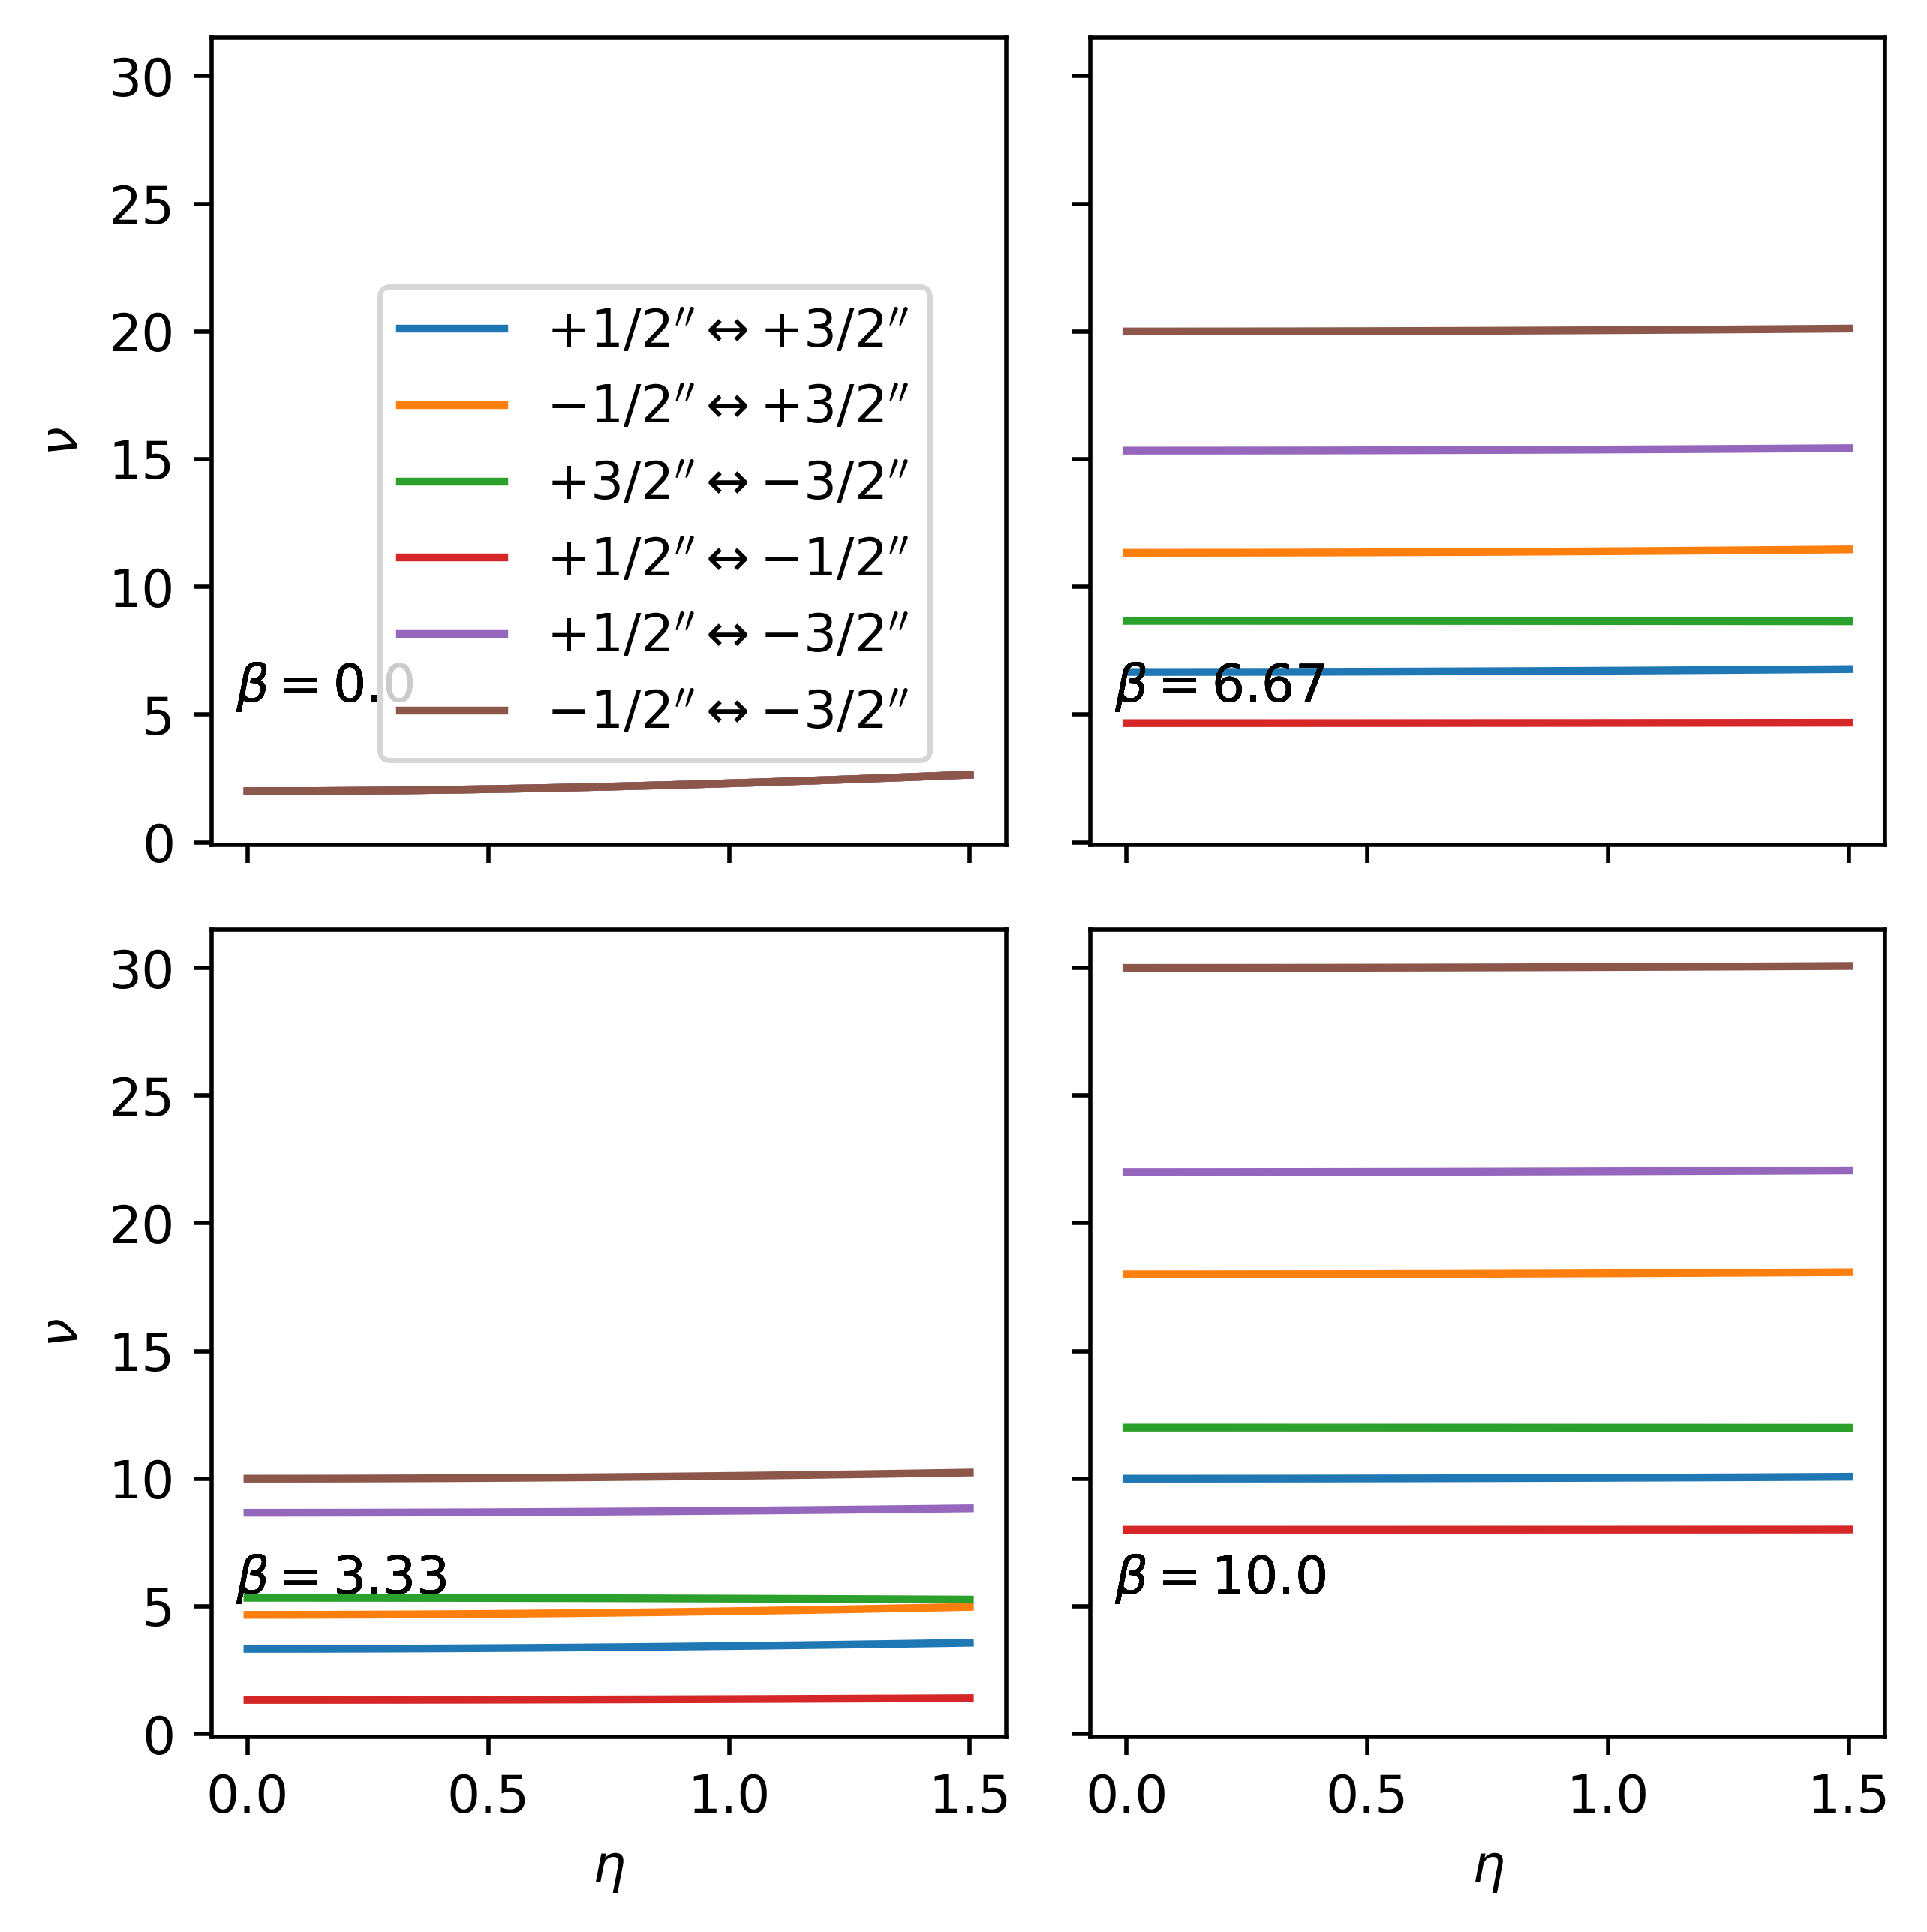

In [17]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        sharex=True,
                        sharey=True,
                        figsize=(5.25, 5.25),
                        dpi=500)

beta = np.linspace(0, 10, 4).reshape([2, 2]).T
eta = np.linspace(0, 1.5)
t_labels = {0: r"$+3/2''$", 1: r"$+1/2''$", 2: r"$-1/2''$", 3: r"$-3/2''$"}
for t in sym.freq:
    p, q = t
    v = sp.lambdify([sym.beta, sym.eta], (sym.freq[t]))
    for j in range(2):
        for k in range(2):
            freq = np.abs(v(beta[j, k], eta))
            if (j, k) == (0, 0):
                if np.all(np.isclose(freq, 0)):
                    axs[j, k].plot([], [], label=t_labels[p] + r'$\leftrightarrow$' + t_labels[q])
                else:
                    axs[j, k].plot(eta, freq, label=t_labels[p] + r'$\leftrightarrow$' + t_labels[q])
            else:
                axs[j, k].plot(eta, freq)
            axs[j, k].annotate(r'$\beta =' + f'{np.round(beta[j, k], 2)}' + r'$', xy=(-0.025, 5.5), xycoords='data')
            #axs[j, k].set_ylim(0, 6.5)
axs[0, 0].set_ylabel(r"$\nu$")
axs[1, 0].set_ylabel(r"$\nu$")
axs[1, 0].set_xlabel(r"$\eta$")
axs[1, 1].set_xlabel(r"$\eta$")
fig.tight_layout()
axs[0, 0].legend(loc='lower left', bbox_transform=axs[0, 0].transData, bbox_to_anchor=(0.22, 2.2))
#fig.savefig('../reports/s32_report/freqs.jpg', bbox_inches='tight')

In [28]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        sharex=True,
                        sharey=True,
                        figsize=(5.25, 5.25),
                        dpi=500)

eta = np.linspace(0, 1, 4).reshape([2, 2]).T
beta = np.linspace(0, 2)
t_labels = {0: r"$+3/2''$", 1: r"$+1/2''$", 2: r"$-1/2''$", 3: r"$-3/2''$"}
colors = [plt.cm.nipy_spectral(i) for i in np.linspace(0, 1, len(sym.freq))]
for j in range(2):
    for k in range(2):
        axs[j, k].set_prop_cycle('color', colors)
        axs[j, k].tick_params(right=True)
        for t in sym.freq:
            p, q = t
            v = sp.lambdify([sym.beta, sym.eta], (sym.freq[t]))
            freq = np.abs(v(beta, eta[j, k]))
            if (j, k) == (0, 0):
                if np.all(np.isclose(freq, 0)):
                    axs[0, 0].plot([], [], label=t_labels[p] + r'$\leftrightarrow$' + t_labels[q])
                else:
                    axs[0, 0].plot(beta, freq, label=t_labels[p] + r'$\leftrightarrow$' + t_labels[q])
            else:
                axs[j, k].plot(beta, freq)
            axs[j, k].annotate(r'$\eta =' + f'{np.round(eta[j, k], 2)}' + r'$', xy=(-0.025, 5.5), xycoords='data')
            #axs[j, k].set_ylim(0, 6.5)
axs[0, 0].set_ylabel(r"$\nu$")
axs[1, 0].set_ylabel(r"$\nu$")
axs[1, 0].set_xlabel(r"$\beta$")
axs[1, 1].set_xlabel(r"$\beta$")
fig.tight_layout()
axs[0, 0].legend(loc='lower left', bbox_transform=axs[0, 0].transData, bbox_to_anchor=(0.22, 2.2))
#fig.savefig('/Users/jaafar/Documents/school/784phys/final/freqs.jpg', bbox_inches='tight')

Some of these transitions will be weaker than others, so we calculate the magnetic moment of each frequency to determine its intensity. We first create Python lambda functions that we can use to store the magnetic moment expressions and treat as Python functions.

In [30]:
sym.sigma1, sym.sigma2, sym.sigma3, sym.t = sp.symbols('sigma_1 sigma_2 sigma_3 t')
sym.sigma = sp.Matrix([sym.sigma1, sym.sigma2, sym.sigma3])
sigma_subs = {sym.sigma1: msigma(1), sym.sigma2: msigma(2), sym.sigma3: msigma(3)}
I = sp.Rational(3, 2)
sym.Iexp = {}
sym.Iexp['x'] = {}
sym.Iexp['y'] = {}
sym.Iexp['z'] = {}
up = sp.Matrix([1, 0])
down = sp.Matrix([0, 1])
c = [None]*3
c[0] = sp.Matrix([0, 0, 1]).dot([1, 0, 0])
c[1] = sp.Matrix([0, 0, 1]).dot([0, 1, 0])
c[2] = sp.Matrix([0, 0, 1]).dot([0, 0, 1])
sym.mat = {}
sym.mat['x'] = {}#sp.Matrix(np.zeros((4, 4)))
sym.mat['y'] = {}#sp.Matrix(np.zeros((4, 4)))
sym.mat['z'] = {}#sp.Matrix(np.zeros((4, 4)))
for d in ['x', 'y', 'z']:
    for i, tran in enumerate(sym.freq):
        p, q = tran
        Xp, Xq = sym.V[p], sym.V[q]/sp.sqrt(sym.V[q].dot(sym.V[q]))
        wpq = (sym.freq[tran])
        mat = Xp.T*sym.I[d]*Xq
        sym.mat[d][tran] = sp.lambdify([sym.beta, sym.eta], mat)
        compi, compj = 0, 0
        for m, d2 in enumerate(['x', 'y', 'z']):
            matm = (Xp.T*sym.I[d2]*Xq)[0]
            compi += c[m]*sp.re(matm)
            compj += c[m]*sp.im(matm)
        if compi != 0 or compj != 0:
            nhat = (sp.Matrix([compi, compj, 0])/sp.sqrt(compi**2 + compj**2))
            Vmid = (nhat.cross(sym.sigma)[2]).subs(sigma_subs)
            _Iexp = wpq/(2*(2*I + 1))*(down.T*Vmid*up)*mat*sp.exp(sp.I*wpq*sym.t)
            Iexp = _Iexp[0]# + sp.conjugate(_Iexp[0])
            sym.Iexp[d][tran] = sp.lambdify([sym.beta, sym.eta, sym.t], Iexp)
        #else:
        #    sym.Iexp[d][tran] = sp.lambdify([sym.alpha, sym.delta, sym.t], 0)

With the functions defined, we can now visualize the spectrum.

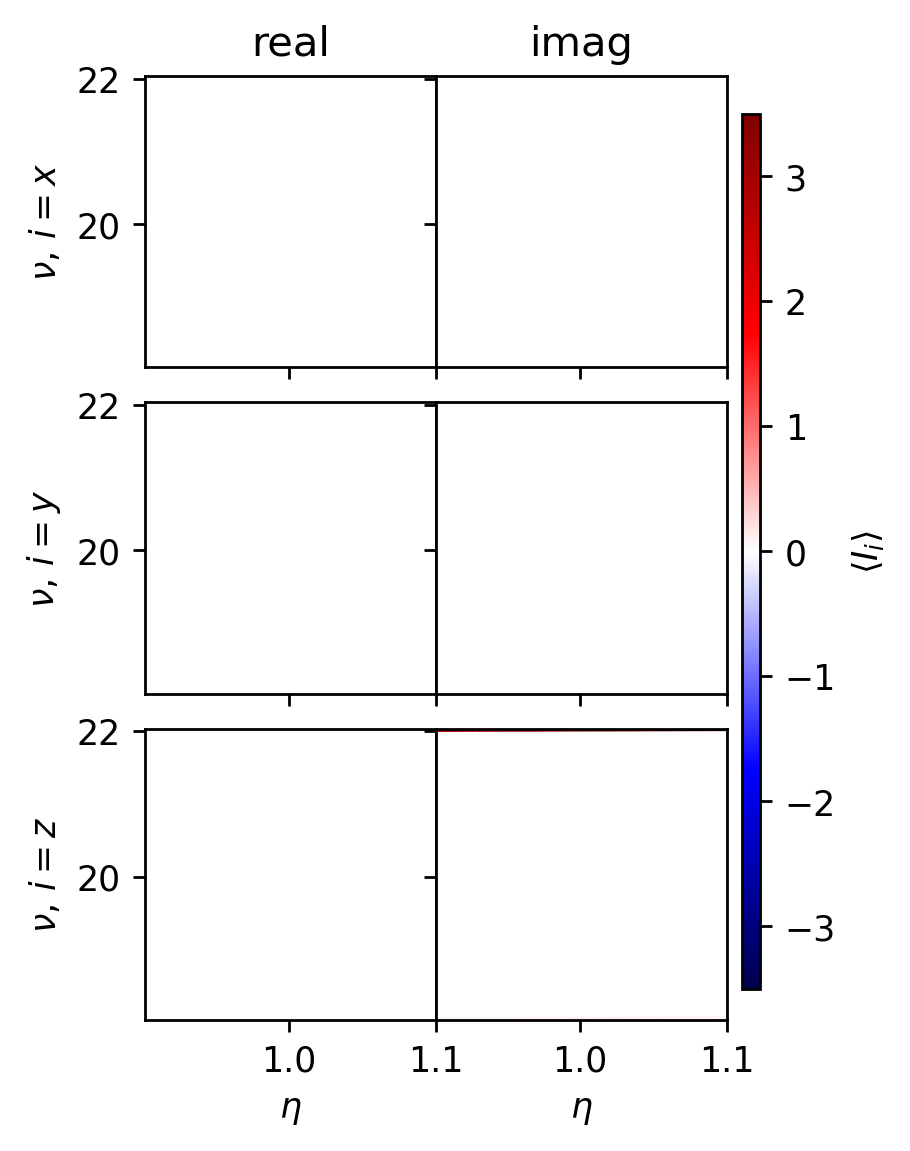

In [31]:
beta = 10
eta = np.linspace(0.9, 1.1, 100)[1:]
xdata = {}
ydata = {}
cdata = {}
for i, d in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[d]
    xdata[d] = {}
    ydata[d] = {}
    cdata[d] = {}
    for j, tran in enumerate(Iexp):
        p, q = tran
        wpq = sp.lambdify([sym.beta, sym.eta], sp.Abs(sym.freq[tran]))(beta, eta)
        x = eta.copy()
        y = wpq.copy()
        _Iexp = Iexp[tran](beta, eta, 0)
        if np.any(_Iexp != 0):
            c = _Iexp
            xdata[d][tran] = x.copy()
            ydata[d][tran] = y.copy()
            cdata[d][tran] = (c).copy()
        else:
            xdata[d][tran] = x.copy()
            ydata[d][tran] = y.copy()
            cdata[d][tran] = np.zeros(eta.size)

fig, ax = plt.subplots(nrows=3, ncols=2,
                       sharex=True,
                       sharey=True,
                       gridspec_kw = {'hspace': 0.12, 'wspace': 0},
                       figsize=(3, 5),
                       dpi=250)
cmin, cmax = 100, -100
for i, d in enumerate(cdata):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    if len(cdata_list) != 0:
        for k in [0, 1]:
            func = {0: np.real, 1: np.imag}
            _cmax, _cmin = find_max_min([func[k](c) for c in cdata_list])
            if _cmax > cmax:
                cmax = _cmax
            if _cmin < cmin:
                cmin = _cmin
cmax, _ = find_max_min([np.abs(cmin), np.abs(cmax)])
for i, d in enumerate(['x', 'y', 'z']):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    ymax, ymin = find_max_min(ydata_list)
    norm = plt.Normalize(-cmax, cmax)
    for j, tran in enumerate(cdata[d]):
        x = xdata[d][tran]
        y = ydata[d][tran]
        for k in [0, 1]:
            func = {0: np.real, 1: np.imag}
            c = func[k](cdata[d][tran])
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = mpl.collections.LineCollection(segments, cmap='seismic', norm=norm)
            lc.set_array(c)
            line = ax[i, k].add_collection(lc)
            ax[i, k].set_xlim(eta.min(), eta.max())
            ax[i, k].set_ylim(ymin, ymax)
            ax[i, k].set_facecolor("white")
            ax[-1, k].set_xlabel(r'$\eta$')
        ax[i, 0].set_ylabel(r"$ \nu,\, i = " + d + "$")
ax[0, 0].set_title('real')
ax[0, 1].set_title('imag')
cbar_ax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
cbar = fig.colorbar(line, cax=cbar_ax)#ax[:, 2], location='right')#, shrink=0.6)
#fig.tight_layout()
cbar.set_label(r"$\langle I_i \rangle$")#/(E_{m''} - E_{n''})$")
fig.savefig('../reports/s32_report/magmom.jpg', bbox_inches='tight')

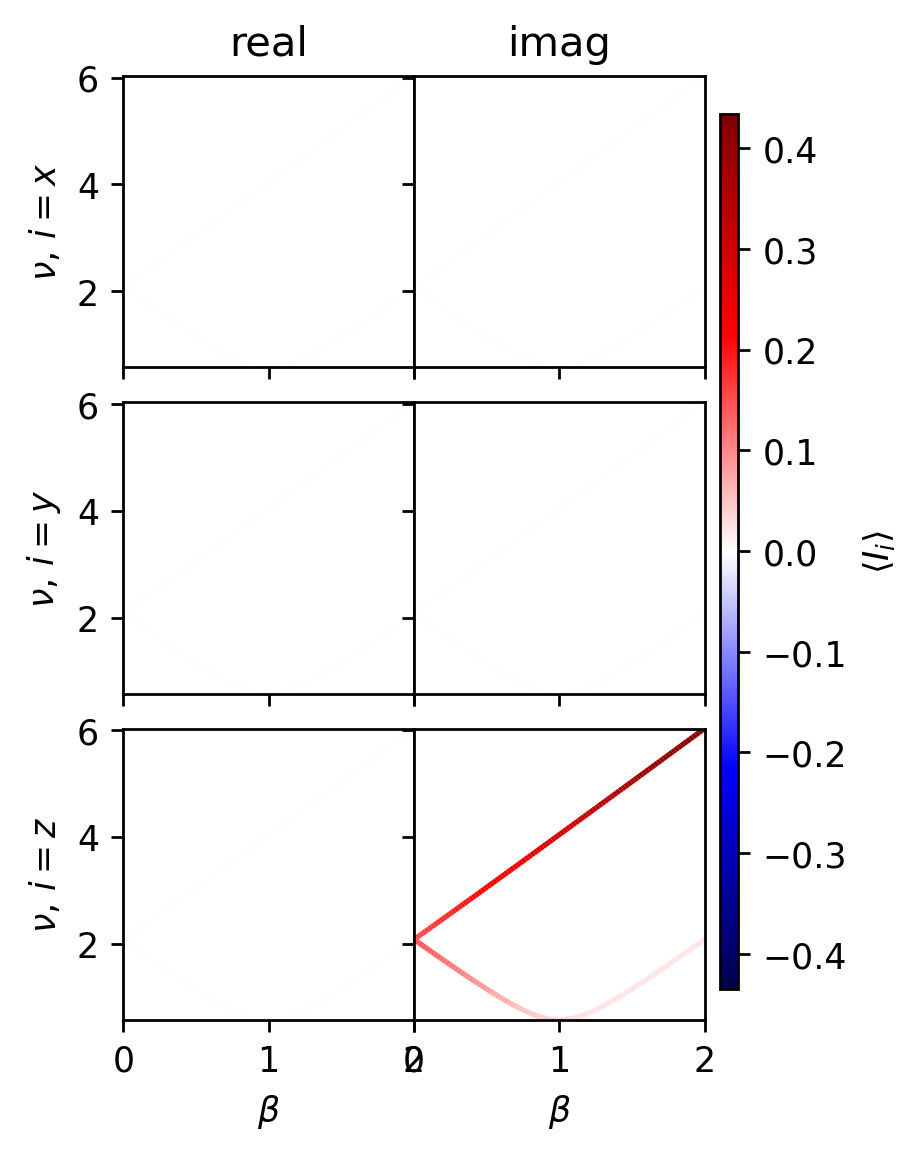

In [32]:
eta = 0.5
beta = np.linspace(0, 2, 100)
xdata = {}
ydata = {}
cdata = {}
for i, d in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[d]
    xdata[d] = {}
    ydata[d] = {}
    cdata[d] = {}
    for j, tran in enumerate(Iexp):
        p, q = tran
        wpq = sp.lambdify([sym.beta, sym.eta], sp.Abs(sym.freq[tran]))(beta, eta)
        x = beta.copy()
        y = wpq.copy()
        _Iexp = Iexp[tran](beta, eta, 0)
        if np.any(_Iexp != 0):
            c = _Iexp
            xdata[d][tran] = x.copy()
            ydata[d][tran] = y.copy()
            cdata[d][tran] = (c).copy()
        else:
            xdata[d][tran] = x.copy()
            ydata[d][tran] = y.copy()
            cdata[d][tran] = np.zeros(beta.size)

fig, ax = plt.subplots(nrows=3, ncols=2,
                       sharex=True,
                       sharey=True,
                       gridspec_kw = {'hspace': 0.12, 'wspace': 0},
                       figsize=(3, 5),
                       dpi=250)
cmin, cmax = 100, -100
for i, d in enumerate(cdata):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    if len(cdata_list) != 0:
        for k in [0, 1]:
            func = {0: np.real, 1: np.imag}
            _cmax, _cmin = find_max_min([func[k](c) for c in cdata_list])
            if _cmax > cmax:
                cmax = _cmax
            if _cmin < cmin:
                cmin = _cmin
cmax, _ = find_max_min([np.abs(cmin), np.abs(cmax)])
for i, d in enumerate(['x', 'y', 'z']):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    ymax, ymin = find_max_min(ydata_list)
    norm = plt.Normalize(-cmax, cmax)
    for j, tran in enumerate(cdata[d]):
        x = xdata[d][tran]
        y = ydata[d][tran]
        for k in [0, 1]:
            func = {0: np.real, 1: np.imag}
            c = func[k](cdata[d][tran])
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = mpl.collections.LineCollection(segments, cmap='seismic', norm=norm)
            lc.set_array(c)
            line = ax[i, k].add_collection(lc)
            ax[i, k].set_xlim(beta.min(), beta.max())
            ax[i, k].set_ylim(ymin, ymax)
            ax[i, k].set_facecolor("white")
            ax[-1, k].set_xlabel(r'$\beta$')
        ax[i, 0].set_ylabel(r"$ \nu,\, i = " + d + "$")
ax[0, 0].set_title('real')
ax[0, 1].set_title('imag')
cbar_ax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
cbar = fig.colorbar(line, cax=cbar_ax)#ax[:, 2], location='right')#, shrink=0.6)
#fig.tight_layout()
cbar.set_label(r"$\langle I_i \rangle$")#/(E_{m''} - E_{n''})$")
#fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'high_magmom.jpg'), bbox_inches='tight')

In [ ]:

for i in range(4):
    expand = sp.series(sym.E[i], 1/sym.beta)
    display(sym.E[i])

In [ ]:
56.25e6/(4.596163e7/(2*np.pi)) - 7.6999

In [ ]:
dp, dm = sp.symbols('d_+ d_-')
expr1 = sym.freq[(1, 0)] - dp
expr2 = sym.freq[(2, 3)] - dm
sol = sp.nonlinsolve([expr1, expr2], [sym.beta, sym.eta])

In [ ]:
sol

In [ ]:
nu1, nu2, nuL, nuQ, C, rho = sp.symbols('nu_1 nu_2 nu_L nu_Q C rho', real=True)
from sympy.solvers.solveset import linsolve, nonlinsolve

# ngp = sp.sqrt((nuL + nuQ)**2 + (nuQ*sym.eta)**2/3)
# ngm = sp.sqrt((nuL - nuQ)**2 + (nuQ*sym.eta)**2/3)
ngp = sp.sqrt(nuL**2 + 2*nuL*nuQ + (rho*nuQ)**2)
ngm = sp.sqrt(nuL**2 - 2*nuL*nuQ + (rho*nuQ)**2)
c = (nu1 + nu2 - 2*nuL)**2/4

expr1 = nuL + ngm + ngp - nu1
expr2 = nuL - ngm + ngp - nu2
sol = sp.solve([expr1, expr2], [nuQ, rho])
expr1

In [ ]:
sym.nu1, sym.nu2, sym.nu3, sym.nuL, sym.nuQ, sym.rho = sp.symbols('nu_1 nu_2 nu_3 nu_L nu_Q rho', real=True)

def find_params(t1, t2):
    subs = {sym.nuQ*sym.beta: sym.nuL,
            sym.nuQ*sp.sqrt(sym.beta**2 + 2*sym.beta + 1 + sym.eta**2/3):
                sp.sqrt(sym.nuL**2 + 2*sym.nuL*sym.nuQ + (sym.rho*sym.nuQ)**2),
            sym.nuQ*sp.sqrt(sym.beta**2 - 2*sym.beta + 1 + sym.eta**2/3):
                sp.sqrt(sym.nuL**2 - 2*sym.nuL*sym.nuQ + (sym.rho*sym.nuQ)**2)}
    if t1 not in sym.freq:
        t1 = t1[::-1]
    if t2 not in sym.freq:
        t2 = t2[::-1]
    expr1 = sp.expand(sym.nuQ*sym.freq[t1]).subs(subs) - sym.nu1
    expr2 = sp.expand(sym.nuQ*sym.freq[t2]).subs(subs) - sym.nu2
    
    return sp.solve([expr1, expr2], [sym.nuQ, sym.rho])

def find_params3(t1, t2, t3):
    subs = {sym.nuQ*sym.beta: sym.nuL,
            sym.nuQ*sp.sqrt(sym.beta**2 + 2*sym.beta + 1 + sym.eta**2/3):
                sp.sqrt(sym.nuL**2 + 2*sym.nuL*sym.nuQ + (sym.rho*sym.nuQ)**2),
            sym.nuQ*sp.sqrt(sym.beta**2 - 2*sym.beta + 1 + sym.eta**2/3):
                sp.sqrt(sym.nuL**2 - 2*sym.nuL*sym.nuQ + (sym.rho*sym.nuQ)**2)}
    if t1 not in sym.freq:
        t1 = t1[::-1]
    if t2 not in sym.freq:
        t2 = t2[::-1]
    expr1 = sp.expand(sym.nuQ*sym.freq[t1]).subs(subs) - sym.nu1
    expr2 = sp.expand(sym.nuQ*sym.freq[t2]).subs(subs) - sym.nu2
    expr3 = sp.expand(sym.nuQ*sym.freq[t3]).subs(subs) - sym.nu3
    
    return sp.nonlinsolve([expr1, expr2, expr3], [sym.nuL, sym.nuQ, sym.rho])

def convert_params(nuq, rho):
    Q = 0.314e-28
    return 4*h*nuq/(e_charge*Q), np.sqrt(3*(rho**2 - 1))

In [ ]:
# BaFe2As2
sol_Ba = {}
sol_Ba[0] = find_params3((1, 0), (3, 2), (2, 1))
# sol[1] = find_params((1, 0), (0, 3))
# sol[2] = find_params((0, 3), (3, 2))

In [ ]:
# BaFe2As2 Continued
#(12-8)*1e6/2/gamma
gamma = 4.596163e7/(2*np.pi) # Hz/T
gamma/1e4*1e3/1e6


In [ ]:
# LaFeAsO
sol_La = {}
sol_La[0] = find_params((1, 0), (3, 2))
sol_La[1] = find_params((1, 0), (0, 3))
sol_La[2] = find_params((0, 3), (3, 2))

In [ ]:
# LaFeAsO Continued
v = [sym.nuQ, sym.rho]
nu2 = 11.8*1e6 # Hz
nu1 = nu2 + 8.8e6 # Hz
Q = 0.314e-28 # m^2
gamma = 4.596163e7/(2*np.pi) # Hz/T
Bi = 1.6 # T
nuL = gamma*Bi
for k in sol:
    for i in sol[k]:
        nuq = i[0]
        rho = i[1]
        eta = sp.sqrt(3*(rho**2 - 1))
        nuqf = sp.lambdify([sym.nu1, sym.nu2, sym.nuL], nuq)
        etaf = sp.lambdify([sym.nu1, sym.nu2, sym.nuL], eta)
        display(nuq)
        display(eta)
        print(4*h*nuqf(nu1, nu2, nuL)/(e_charge*Q), etaf(nu1, nu2, nuL))
    print('='*80)

# Parameters

In [ ]:
sym.w1, sym.w2, sym.wi = sp.symbols('omega_1 omega_2 omega_i', real=True, positive=True)
sym.x, sym.y, sym.p1, sym.p2, sym.r, sym.wt = sp.symbols(r'x y p_1 p_2 r \tilde{w}_2', real=True)
sym.p1, sym.p2, sym.p3, sym.p4, sym.p5, sym.p6 = sp.symbols('p_1 p_2 p_3 p_4 p_5 p_6', real=True)
f1 =  sym.p1 + sym.p2*sp.sqrt(sym.ap**2 + sym.s**2) + sym.p3*sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
f2 =  sym.p4 + sym.p5*sp.sqrt(sym.ap**2 + sym.s**2) + sym.p6*sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
subs = {sym.am*sp.sqrt(1 + sym.s**2/sym.am**2): sym.x, sp.sqrt(sym.ap**2 + sym.s**2): sym.y}
exp1 = f1/f2 - sym.w1/sym.w2
exp2 = sym.wi*f2 - sym.w2
sol = sp.nonlinsolve([exp1.subs(subs), exp2.subs(subs)], [sym.x, sym.y])
xy_sol = list(sol)[0]
display(exp1, exp2, xy_sol)

In [ ]:
sym.c1, sym.c2 = sp.symbols('c_1 c_2', real=True)
x, y = xy_sol
exp1 = sym.am*sp.sqrt(1 + sym.s**2/sym.am**2) + sym.c1
exp2 = sp.sqrt(sym.ap**2 + sym.s**2) - sym.c2
as_sol = sp.solve([exp1, exp2], [sym.ap, sym.am])
display(exp1, exp2, as_sol[0], as_sol[1])

In [ ]:
J = sp.symbols('J', real=True)
subs = {sym.s: sp.sin(sym.D)}
exp1 = ((sym.alpha + sp.cos(sym.D))**2 - as_sol[1][0]**2).subs(subs).expand().trigsimp().subs(sp.cos(sym.D), J)
exp2 = ((sym.alpha - sp.cos(sym.D))**2 - as_sol[1][1]**2).subs(subs).expand().trigsimp().subs(sp.cos(sym.D), J)
#sol = sp.nonlinsolve([exp1, exp2], [sym.alpha, sp.cos(sym.D)]).simplify()
sol = sp.nonlinsolve([exp1, exp2], [sym.alpha, J]).simplify()
display(exp1, exp2, sol)

In [ ]:
def get_c(w1, w2, wi, _p1, _p2):
    p1, p2, p3 = tuple(_p1)
    p4, p5, p6 = tuple(_p2)
    
    den = wi*(p2*p6 - p3*p5)
    c1_num = w1*p5 - w2*p2 + wi*(p2*p4 - p1*p5)
    c2_num = w1*p6 - w2*p3 + wi*(p3*p4 - p1*p6)

    if den == 0:
        return np.inf, np.inf
    else:
        return c1_num/den, c2_num/den

v = [None]*3
v[0] = sym.s
v[1] = sp.sqrt(sym.ap**2 + sym.s**2)
v[2] = sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
w1 = 11.7*mega
w2 = w1 + 8.8*mega
wi = 1.6*7.292*mega
for t1 in sym.f:
    for t2 in sym.f:
        f1 = sym.f[t1]
        f2 = sym.f[t2]
        p1, p2 = (np.zeros(3) for i in range(2))
        for i in range(3):
            n = 1
            if i == 0:
                n = 0
            p1[i], p2[i] = (f1.as_expr().coeff(v[i], n), f2.as_expr().coeff(v[i], n))
        c1, c2 = get_c(w1, w2, wi, p1, p2)
        if not np.all([np.isfinite(val) for val in [c1, c2]]):
            continue
        if c1**2 + c2**2 - 2 < 0:
            continue
        factor = np.sqrt(2*(c1**2 + c2**2 - 2))
        alpha = factor/2 
        cosD = (c1**2 - c2**2)/2/factor
        if cosD > 1 or -cosD > 1:
            continue
        cosD = np.abs(cosD)
        D = np.arccos(cosD)
        subs = {sym.alpha: alpha, sym.D: D}
        f1_val = np.float(f1.subs(sym.subs).subs(subs).evalf())
        f2_val = np.float(f2.subs(sym.subs).subs(subs).evalf())
        Iexp_t1 = np.real(sym.Iexp['y'][t1](alpha, D))
        Iexp_t2 = np.real(sym.Iexp['y'][t2](alpha, D))
        if not np.isclose([f1_val/f2_val], [w1/w2]) or np.any(np.isnan([Iexp_t1, Iexp_t2])):
            continue
        if D > np.pi/6:
            continue
        print('trans: ', t1, t2)
        print("params: ", alpha, cosD)
        print("freqs: ", f1_val, f2_val)
        print("checks: ", wi*f1_val, w1, f1_val/f2_val, w1/w2, wi*f2_val, w2)
        print('-'*80)

In [ ]:
from scipy.constants import h, hbar, e
I = 3/2
gamma = 7.315021*mega
Bi = 1.60
Q = nmr.get_Q('As', 75).n
wi = gamma*Bi
cosD = 0.9917172851021455
alpha = 0.3822292454941639
delta = np.arccos(cosD)/2
rho = 1/(1 - 2*Q*(4*I*(2*I - 1)*h)/(3*e*Q)
etanp.sin(delta)**2)
wQ = alpha*wi/rho
Vzz = w = np.sqrt((rho**2 - 1)*3)
Bi, gamma, wi, Q, wQ, Vzz, eta